In [1]:
# # HTML header to hide raw code, taken from
# # http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/

# from IPython.display import HTML

# HTML('''<script>
#   function code_toggle() {
#     if (code_shown){
#       $('div.input').hide('500');
#       $('#toggleButton').val('Show Code')
#     } else {
#       $('div.input').show('500');
#       $('#toggleButton').val('Hide Code')
#     }
#     code_shown = !code_shown
#   }

#   $( document ).ready(function(){
#     code_shown=false;
#     $('div.input').hide()
#   });
# </script>
# <form action="javascript:code_toggle()"><input type="submit''')

# AFNI Preprocessing

We'd like to preprocess a single subject using AFNI, and look at the images at every step.

The raw code for this [Jupyter Notebook](http://jupyter.org/) is by default hidden for easier reading.
To toggle on/off the raw code, click the button below.

In [2]:
# HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
% matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import os, glob
import numpy as np
from nilearn import image, input_data, plotting
from nipype.interfaces import afni as afni

Next, we'll need some data. We'd visualize the effects of preprocessing on raw fMRI data. so let's just import a single subject's data for now. We'll be using sub-001 from ds000164 on the OpenfMRI project, where subjects engaged in a Stroop task (now a [board game](https://boardgamegeek.com/boardgame/212376/stroop)!). 

To save time, I've already downloaded this dataset for you. You'll find it in the running docker container at /PATH/TO/DATA/TO/BE/UPDATED.

In [4]:
sub_dir = os.path.join('/home', 'emd222', 'Desktop', 'HD4630_workshops', 'ds000164_R1.0.0', 'sub-001')
anat_img = os.path.join(sub_dir, 'anat', 'sub-001_T1w.nii.gz')
func_img = os.path.join(sub_dir, 'func', 'sub-001_task-stroop_bold.nii.gz')
func_fname = os.path.basename(func_img).split(os.extsep)[0]

os.chdir(os.path.join(sub_dir, 'func'))

It's always important to look at your data, so we'll start with a few visualizations of the raw scans. Before we dive into the functional data, let's look at this subject's anatomical image.

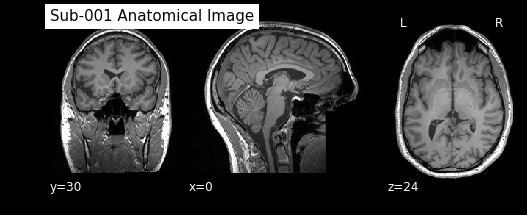

In [5]:
plotting.plot_anat(anat_img, display_mode='ortho',
                   cut_coords=[0, 30, 24], dim=-1,
                   draw_cross=False,
                   title='Sub-001 Anatomical Image')

Do you notice anything missing here? 

This image has been "defaced;" that is, the face has been cropped out. This is a common step in sharing data publicly, and it serves to minimize the possibility that future technology could identify a participant from their fMRI scans. 

For our purposes, the only possible side effect of defacing is impaired coregistration between the anatomical and functional images for our participants. This is unlikely, but something we'll look out for as we move forward with preprocessing.

The next thing we'd like to look at is the raw fMRI data itself. Since the first time to repetition (TR) has the highest contrast, we'll start there.

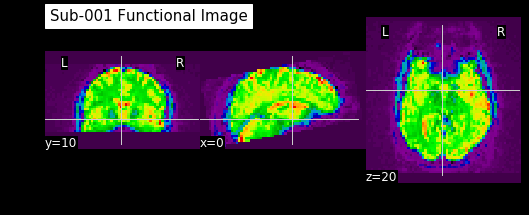

In [6]:
first_tr = image.index_img(func_img, 0)

plotting.plot_epi(first_tr, display_mode='ortho',
                  cut_coords=[0, 10, 20], 
                  draw_cross=True,
                  title='Sub-001 Functional Image')

One thing to note in the above code is that Python (and AFNI) use 0-indexing, which means that the first TR is known as volume 0 rather than volume 1. This will be important later. 

The image itself is not a pretty sight, but this is about what we'd expect from a raw functional image. Let's get this cleaned up so we can make a little more sense of what's going on.

---
## Step 1. Slice Timing Correction

The first thing we'll need to do is slice timing correction. This involves taking the individually acquired slices and shifting them so that we can treat each volume as instantaneously collected on the TR.

For this dataset, we know that the TR is 1.5 seconds and slices were acquired in a bottom-up fashion. We'll supply that information as parameters to AFNI's 3dTshift to motion correct the data. First, we'll drop the first 4 TRs to account for stabilization scans. 

In [7]:
tshift_prefix = (func_fname + '_tshift.nii.gz')
tshift = afni.TShift() 

# parameters we're supplying for slice timing correction
tshift.inputs.in_file = func_img # the file to slice time correct
tshift.inputs.ignore = 4 # ignore the first four volumes
tshift.inputs.tr = '1.5s' # the TR
tshift.inputs.tpattern = 'seqplus' # the slice acquisition order
tshift.inputs.outputtype='NIFTI_GZ' # save in our familiar format
tshift.inputs.out_file=os.path.join(sub_dir, 'func', tshift_prefix) # save to the subject 'func' directory

res = tshift.run() 
clear_output()
print('Slice timing correction finished.')

Slice timing correction finished.


Now that slice timing correction is done, let's see what effect it had on the image. Since this is difficult to see this by eye, we'll extract signal from a small sphere centered on the coordinate shown in 'Sub-001 Functional Image' and plot its signal before and after slice time correction.

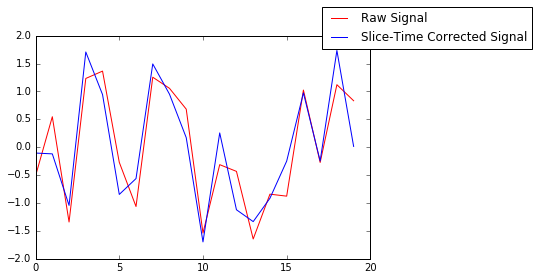

In [8]:
# Selecting the coordinate shown above in the epi image
coords = [(0, 10, 20)]
masker = input_data.NiftiSpheresMasker(
    coords, radius=3,
    detrend=True, standardize=True,
    t_r=1.5)

# show activity in this coordinate from vols 4-24 
# in the raw, uncorrected fMRI image in red
orig_img = image.index_img(func_img, slice(4,24))
time_series = masker.fit_transform(orig_img)
for time in time_series.T:
    plt.plot(time, 'r', label='Raw Signal')

# show activity in this coordinate from vols 4-24 
# in the slice time corrected fMRI image in blue
tshift_img = image.index_img(os.path.join(sub_dir, 'func', tshift_prefix), slice(4,24))
time_series = masker.fit_transform(tshift_img)
for time in time_series.T:
    plt.plot(time, 'b', label='Slice-Time Corrected Signal')

ax = plt.subplot(111)
ax.legend(bbox_to_anchor=(1.50, 1.155))
plt.show()

---
## Step 2. Motion Correction

Fill in info here.

In [9]:
volreg_prefix = (func_fname + '_vr.nii.gz')
volreg = afni.Volreg() 

# parameters we're supplying for motion correction
volreg.inputs.in_file = os.path.join(sub_dir, 'func', tshift_prefix) # the file to motion correct
volreg.inputs.args = '-heptic'
volreg.inputs.zpad = 1
volreg.inputs.outputtype='NIFTI_GZ' # save in our familiar format
volreg.inputs.out_file=os.path.join(sub_dir, 'func', volreg_prefix) # save to the subject 'func' directory

res = volreg.run() 
clear_output()
print('Motion correction finished.')

Motion correction finished.


Fill in info here too!

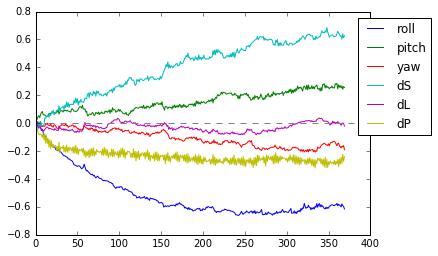

In [10]:
six_params = np.genfromtxt(func_fname+'_tshift.1D', delimiter='', 
              unpack=True)
labels=['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']

for i in range(6):
    plt.plot(six_params[i], label=labels[i])

line = plt.axhline(y=0, c='grey')
line.set_linestyle('--')

ax = plt.subplot(111)
ax.legend(bbox_to_anchor=(1.2, 1))